In [19]:
import os
import sys
import datetime as dt

os.chdir("../Automated/")
from DataGathering import RedditScraper
from ChangePointAnalysis import ChangePointAnalysis
from NeuralNets import CreateNeuralNets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

subreddit = "WallStreetBets"

# Data Scraping

For analyzing wallstreetbets data, we recommend downloading full.csv from [url] and putting it in ../Data/subreddit_wallstreetbets.

If you want to scrape a different subreddit, you can use the following file. You will need API.env with appropriate credentials in /Automated/

In [2]:

start = dt.datetime(2020, 1, 1)
end =  dt.datetime(2020, 1, 30)

if not os.path.exists(f"../Data/subreddit_{subreddit}/full.csv"):
    print("Did not find scraped data, scraping.")

    RedditScraper.scrape_data(subreddits = [subreddit], start = start, end = end)

# Change Point Analysis

The next cell will open full.csv , compute the words that are among the top daily_words most popular words on any day, and then run the change point analysis model on each of them.


The first time this is a run, a cleaned up version of the dataframe will be created for ease of processing.




In [22]:
up_to = None # Only calculate change points for up_to of the popular words. Set to None to do all of them.
daily_words = 1 # Get the daily_words most popular posts on each day.


# Compute the changepoints
# ChangePointAnalysis.changepointanalysis([subreddit], up_to = up_to, daily_words = daily_words)

# The output has been commented out because it is very long.

After running, these files will in ../Data/subreddit_subreddit/Changepoints/Metropolis_30000Draws_5000Tune

The final folder name corresponds to the parameters of the Markov chain used by pymc3 for the inference.

## Organizing the changepoints

A table of the keywords considered with parameters estimated by the model is stored in :  ../Data/subreddit_{subreddit}/Changepoints/results.csv

You can then sort through these to find the keywords the model detected a change in.

There are two key parameters:

change_point_confidence (also denoted p): the models belief that there was a changepoint. p = 1 indicates yes, p = 0 indicates no.

mu_diff : a measurement of the size of the changepoint.

gme  Change point confidence:  1.0  Change point magnitude:  0.0870740331085252


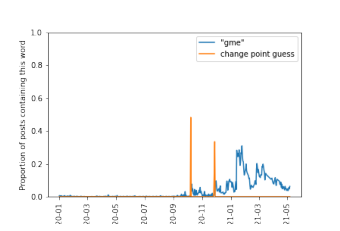

mvis  Change point confidence:  1.0  Change point magnitude:  0.0461819641685697


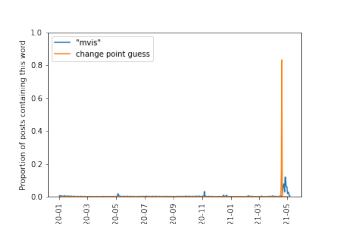

amc  Change point confidence:  1.0  Change point magnitude:  0.0383189130962687


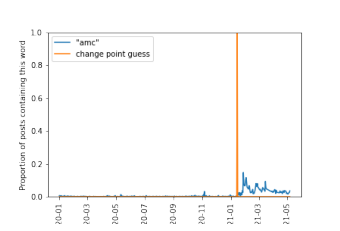

moon  Change point confidence:  1.0  Change point magnitude:  0.0339413340598208


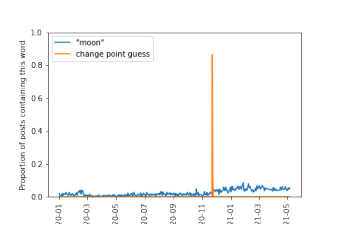

pltr  Change point confidence:  1.0  Change point magnitude:  0.032728299053265


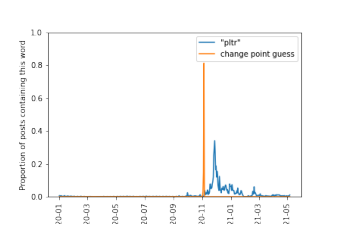

calls  Change point confidence:  1.0  Change point magnitude:  -0.0335557888464715


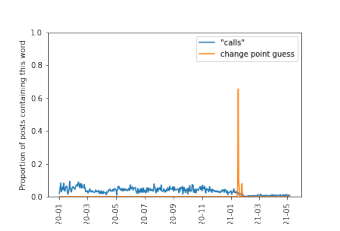

In [54]:
results = pd.read_csv(f"../Data/subreddit_{subreddit}/Changepoints/results.csv")
results = results.rename( columns = {"Unnamed: 0" : "keyword" })
filtered = results[(results.change_point_confidence == 1) & (results.mu_diff.apply(lambda x : np.abs(x)) > .03)]
filtered = filtered.sort_values(by = "mu_diff", ascending = False)
for row in filtered.iterrows():
    word = row[1]["keyword"]
    print(word, " Change point confidence: ", row[1]["change_point_confidence"], " Change point magnitude: ", row[1]["mu_diff"])
    img = mpimg.imread(f'../Data/subreddit_WallStreetBets/Changepoints/Metropolis_30000Draws_5000Tune/ChangePoint_{word}.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

## Warning: 

Sometimes change point confidence alone is not enough. For instance, it was very confident (p = 1) that there was a changepoint in the following, although it wouldn't be reported as a change point because mu_2 - mu_1 was very small (~.003):

![title](../Data/subreddit_WallStreetBets/Changepoints/Metropolis_30000Draws_5000Tune/ChangePoint_new.png)

## Brief explanation of how this model works:

The Bayesian model is as follows:

1. A coin is flipped with probability p.
2. If the coin comes up heads, then there is a change point. Otherwise, there is no change point.
3. It is assumed that the frequency random variable consists of independent draws from a beta distribution. If the coin decided there would be no change point, it is the same beta distribution at all times. Otherwise, it is a different beta on the different sides of the change points.

The posterior distribution of p is the models confidence that there is a change point, and the posterior distribution of tau represents its guess about when it occured.

The variable mu_1 represents the mean of the beta distribution before the change point, and mu_2 represents the mean of the beta distribution after the changepoint.

Of course, this is not a realistic picture of the process; the independence of the different draws from the betas is especially unlike the data. However, it appears to be good enough to discover change points, especially when p and mu_2 - mu_1 are used together.

As currently written, it only handles one change point, however this can be improved.

(This model was inspired by the changepoint example from Chapter 1 of Bayesian Methods for Hackers: Probabilistic Programming and Bayesian Inference.)


# Neural Nets

The following code will train a neural net that predicts, given a submission's title text and time of posting, whether that submission's score will be above the median. 

We use pre-trained GloVe word embeddings in order to convert the title text into a vector that can be used in the neural net. These word embeddings are tuned along with the model parameters as the model is being trained. 

This technique and the neural net's architecture are taken from a blog post of Max Woolf, https://minimaxir.com/2017/06/reddit-deep-learning/.


In [5]:
model, accuracies, word_tokenizer, df = CreateNeuralNets.buildnets(['wallstreetbets'])[0]

Starting Post Classification Model.


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (26,32,45,79,82,87,116,117,118,121,122,123,124) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Epoch 1/20
1134/1134 [==============================] - 98s 58ms/step - loss: 0.7454 - main_out_loss: 0.6063 - aux_out_loss: 0.6957 - main_out_accuracy: 0.6723 - aux_out_accuracy: 0.5042 - val_loss: 0.6840 - val_main_out_loss: 0.5480 - val_aux_out_loss: 0.6802 - val_main_out_accuracy: 0.7165 - val_aux_out_accuracy: 0.5756
Epoch 2/20
1134/1134 [==============================] - 66s 58ms/step - loss: 0.6384 - main_out_loss: 0.5037 - aux_out_loss: 0.6739 - main_out_accuracy: 0.7492 - aux_out_accuracy: 0.5958 - val_loss: 0.6675 - val_main_out_loss: 0.5346 - val_aux_out_loss: 0.6647 - val_main_out_accuracy: 0.7248 - val_aux_out_accuracy: 0.6091
Epoch 3/20
1134/1134 [==============================] - 81s 72ms/step - loss: 0.5735 - main_out_loss: 0.4437 - aux_out_loss: 0.6494 - main_out_accuracy: 0.7905 - aux_out_accuracy: 0.6490 - val_loss: 0.6856 - val_main_out_loss: 0.5551 - val_aux_out_loss: 0.6523 - val_main_out_accuracy: 0.7222 - val_aux_out_accuracy: 0.6274- loss: 0.5634 - main_ou - ET

## Predicted popularity as a time series

We now show how the predicted popularity of a post depends on the day on which it was posted. 
We plot the prediction for the same title, "GME GME GME GME GME GME", as if it were posted at noon each day. 
It is interesting to note that the variance seems to decrease after the GameStop short squeeze of early 2021. 

In [60]:
text = "GME GME GME GME GME GME"
CreateNeuralNets.timeseries(df, text, model, word_tokenizer)

This will produce a picture like the following:
![title](../Data/subreddit_WallStreetBets/6_GME.png)


## Workshopping example
Here we start with a potential title (to be posted at noon on April 1, 2021) and attempt to improve it based on the model's prediction. 

In [43]:
#this is the date information for April 1, 2021. 
#Note we normalize so the earliest year in our data set (2020) 
#and the earliest day of the year correspond to the number 0
input_hour = np.array([12])
input_dayofweek = np.array([3])
input_minute = np.array([0])
input_dayofyear = np.array([91])
input_year = np.array([0])
input_info=[input_hour,input_dayofweek, input_minute, input_dayofyear, input_year]

In [19]:
#given a list of potential titles, predict the success of each one
def CheckPopularity(potential_titles):
    for title in potential_titles:
        print(model.predict([CreateNeuralNets.encode_text(title,word_tokenizer)] + input_info)[0][0][0])

In [21]:
potential_titles = ["Buy TSLA", "Buy TSLA! I like the stock", "Buy TSLA! Elon likes the stock",
                    "TSLA is the next GME. Elon likes the stock", 
                    "TSLA is the next GME. To the moon! Elon likes the stock"]

In [22]:
CheckPopularity(potential_titles)

0.9536921
0.957647
0.9620316
0.98298347
0.983858


We see that the predicted popularity increases after each change we make. 

Disclaimer: we are investigating a last-minute issue. These probabilities are higher than expected from earlier experimentation, and there is the possibility of a bug in our code. 